# Backpropagation

Some inspiration taken from [Matt Mazur's example here](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/).

In [12]:
# Choose basedir as either local or hosted directory
import os
if "COLAB_BACKEND_VERSION" in os.environ:
    base_dir = "/content"
else:
    base_dir = os.getcwd()
# get helper code from the course repository
# install common packages used for deep learning
%cd $base_dir
!git clone https://github.com/cs449s23/lectures.git lectures/
%cd /content/lectures/
!git pull -q origin main
!pip install -q -r requirements.txt

fatal: destination path 'lectures' already exists and is not an empty directory.
/content/lectures
/content/lectures
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.7 MB/s eta 0:00:00


In [24]:
import numpy as np

import matplotlib.pyplot as plt
from utils.plotting import plot_decision_surface, plot_data

In [29]:
def compute_bounds(X):
    min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
    min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1
    return (min1, max1, min2, max2)


def plot_decision_regions(X, y, model):
    bounds = compute_bounds(X)
    plot_data(X, 2 * y - 1)

    def predict(X):
        return 2 * model.predict(X) - 1
        
    plot_decision_surface(predict, bounds)

In [15]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_gradient(x):
    return sigmoid(x) * (1 - sigmoid(x))


def cross_entropy_loss(y_true, y_pred):
    return - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)


def cross_entropy_gradient(y_true, y_pred):
    return (- y_true + y_pred) / (y_pred - y_pred ** 2)

In [16]:
class MLP:
    def __init__(self, learning_rate=1, n_hidden_nodes=8, init_std=0.1):
        self.W1 = np.random.normal(0, init_std, [3, n_hidden_nodes])
        self.W2 = np.random.normal(0, init_std, [1 + n_hidden_nodes, 1])

        self.activation = sigmoid
        self.lr = learning_rate

    def predict(self, X):
        if X.shape[1] == self.W1.shape[0] - 1:
            X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=1)
        self.params = {'X': X}

        tmp = X.dot(self.W1)
        self.params['W1 @ X'] = tmp

        tmp = self.activation(tmp)
        tmp = np.concatenate([np.ones([X.shape[0], 1]), tmp], axis=1)
        self.params['g(W1 @ X)'] = tmp

        tmp = tmp.dot(self.W2)
        self.params['W2 @ g(W1 @ X)'] = tmp

        tmp = self.activation(tmp)
        self.params['g(W2 @ g(W1 @ X))'] = tmp

        return tmp

    def update_weights(self, y_true, y_pred):
        assert self.params != {}

        # ∂L/∂pred
        pd_loss = cross_entropy_gradient(y_true, y_pred)
        # ∂sigmoid(x)/∂x
        pd_second_sigmoid = sigmoid_gradient(self.params['W2 @ g(W1 @ X)'])
        # ∂(W2 @ g(W1 @ X))/∂ W2
        pd_matmul = self.params['g(W1 @ X)']

        # save the post_w2_loss that captures cross entropy and final sigmoid
        post_w2_loss = pd_loss * pd_second_sigmoid
        w2_update = np.mean(post_w2_loss * pd_matmul, axis=0, keepdims=True)
        
        # ∂(W2 @ g(W1 @ X))/∂ g(W1 @ X)
        pd_W2_g = self.W2
        # ∂sigmoid(x)/∂x
        pd_first_sigmoid = sigmoid_gradient(self.params['W1 @ X'])
        # ∂(W1 @ X) /∂W1
        pd_W1_X = self.params['X']

        w1_update = np.zeros_like(self.W1)

        # for each node in the hidden layer ...
        for i in range(self.W1.shape[1]):
            # ... only grab the losses for one specific hidden node
            w1_loss = post_w2_loss * pd_W2_g[i + 1] * pd_first_sigmoid[:, (i, )]
            w1_update[:, i] = np.mean(
                w1_loss * pd_W1_X, axis=0, keepdims=True)

        self.params = {}
        self.W1 -= self.lr * w1_update
        self.W2 -= self.lr * w2_update.T

    def fit(self, X, y, steps=10000, quiet=True):
        if X.shape[1] == self.W1.shape[1] - 1:
            X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=1)
        
        for i in range(steps):
            y_pred = self.predict(X)
            loss = cross_entropy_loss(y, y_pred)
            self.update_weights(y, y_pred)
            if not quiet and (i + 1) % (steps // 10) == 0:
                print(i + 1, np.mean(loss))

In [30]:
def experiment(seed=1, lr=1, init_std=0.1, n_iters=10000, n_hidden_nodes=2,
               bonus=False, plot_before=False, verbose=False):

    np.random.seed(seed)

    # xor dataset
    X = np.array([[1, 1], [1, 0], [0, 1], [0, 0]],
                 dtype=float)
    y = np.array([[0], [1], [1], [0]], dtype=float)

    if bonus:
        X_bonus = np.array([[0.25, 0.75], [0.5, 0.5], [0.75, 0.25]])
        y_bonus = np.array([[0], [1], [0]])
        X = np.concatenate([X, X_bonus], axis=0)
        y = np.concatenate([y, y_bonus], axis=0)

    mlp = MLP(learning_rate=lr,
              init_std=init_std,
              n_hidden_nodes=n_hidden_nodes)

    if plot_before:
        plot_data
        plot_decision_regions(X, y, mlp)
        plt.show()

    mlp.fit(X, y, quiet=not verbose, steps=n_iters)

    print("{:.0f}% accuracy".format(
        100 * np.mean((mlp.predict(X) > 0.5) == y)))
    print(np.round(mlp.W1, 2))
    print(np.round(mlp.W2, 2))

    # plot the new decision boundaries
    plot_decision_regions(X, y, mlp)
    plt.show()
    plt.close('all')

100% accuracy
[[-9.55  3.3 ]
 [ 6.18 -7.81]
 [ 6.18 -7.82]]
[[  7.29]
 [-14.94]
 [-14.69]]


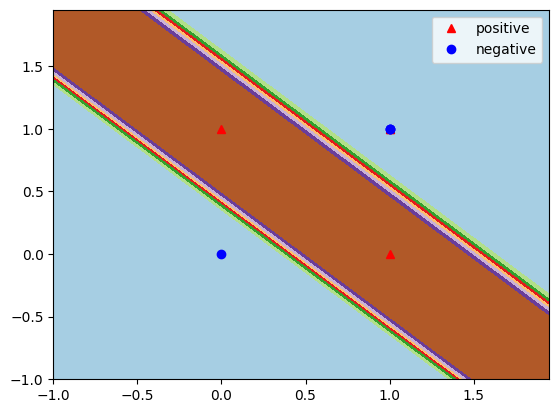

In [31]:
experiment()

50% accuracy
[[0. 0.]
 [0. 0.]
 [0. 0.]]
[[0.]
 [0.]
 [0.]]


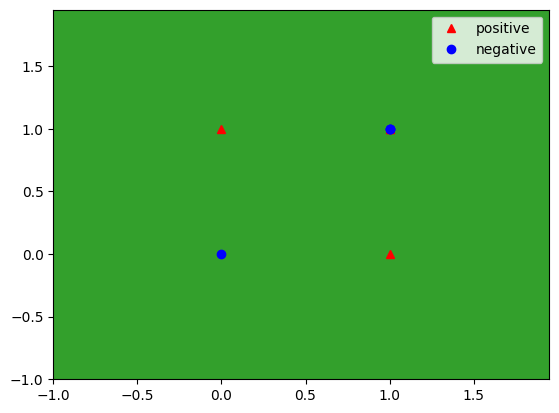

In [34]:
experiment(init_std=0)

71% accuracy
[[-6.43  2.46]
 [ 4.22 -6.19]
 [ 4.22 -6.19]]
[[ 1.53]
 [-9.18]
 [-9.1 ]]


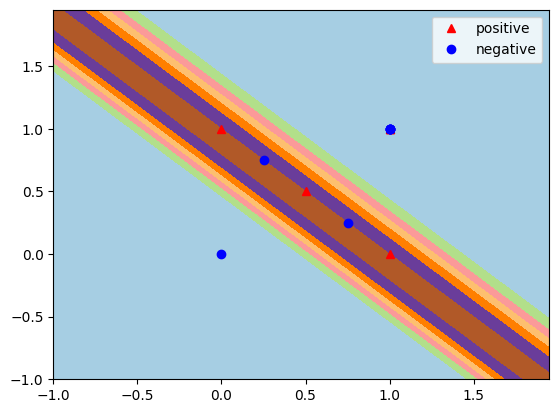

In [32]:
experiment(bonus=True)

100% accuracy
[[  5.83   0.71   4.92  -0.49  -0.57   3.07   2.27   5.66   2.58  -0.67]
 [ 14.86  -2.12  -7.18   0.33   0.35  -6.95  -6.96   6.72  -6.91   0.36]
 [ -8.24   1.56  13.69   0.91   0.8   -6.82   5.46 -12.92   4.59   0.79]]
[[  2.97]
 [-11.73]
 [  3.06]
 [-13.63]
 [  0.52]
 [  0.33]
 [-12.35]
 [  7.02]
 [ 13.78]
 [  6.75]
 [  0.27]]


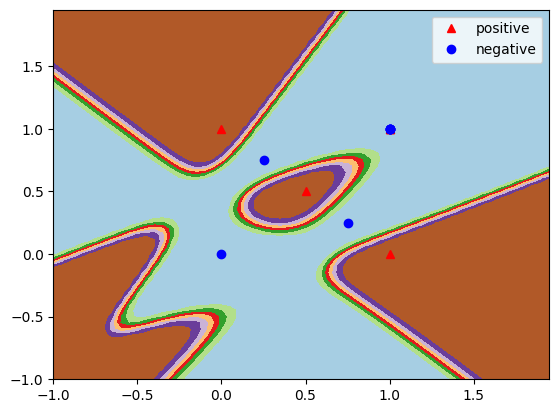

In [33]:
experiment(bonus=True, n_hidden_nodes=10)